# Applying the end-end ML steps to a different dataset.

We will apply what we've learnt to another dataset (airbnb dataset). We will predict airbnb price based on other features.

# [25 pts] Visualizing Data 


### [5 pts] Load the data + statistics

- load the dataset
- display the first few rows of the data
- drop the following columns: name, host_id, host_name, last_review
- display a summary of the statistics of the loaded data
- plot histograms for 3 features of your choice

                 id      latitude     longitude         price  minimum_nights  \
count  4.889500e+04  48895.000000  48895.000000  48895.000000    48895.000000   
mean   1.901714e+07     40.728949    -73.952170    152.720687        7.029962   
std    1.098311e+07      0.054530      0.046157    240.154170       20.510550   
min    2.539000e+03     40.499790    -74.244420      0.000000        1.000000   
25%    9.471945e+06     40.690100    -73.983070     69.000000        1.000000   
50%    1.967728e+07     40.723070    -73.955680    106.000000        3.000000   
75%    2.915218e+07     40.763115    -73.936275    175.000000        5.000000   
max    3.648724e+07     40.913060    -73.712990  10000.000000     1250.000000   

       number_of_reviews  reviews_per_month  calculated_host_listings_count  \
count       48895.000000       38843.000000                    48895.000000   
mean           23.274466           1.373221                        7.143982   
std            44.550582         

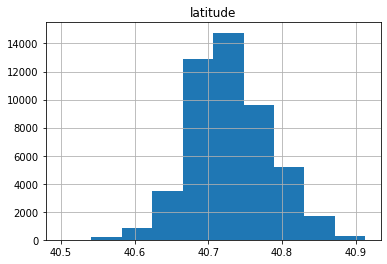

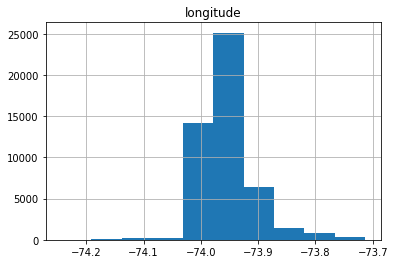

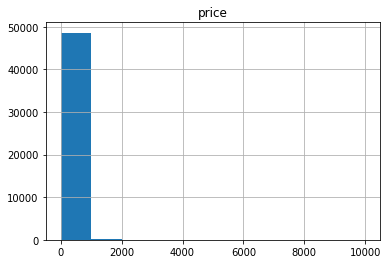

In [34]:
%matplotlib inline 
import matplotlib # plotting library
import matplotlib.pyplot as plt

import os
import sys
import tarfile
import urllib

DATASET_PATH = os.path.join("datasets", "airbnb")

import pandas as pd

def load_airbnb_data(airbnb_path):
    csv_path = os.path.join(airbnb_path, "AB_NYC_2019.csv")
    return pd.read_csv(csv_path)

airbnb = load_airbnb_data(DATASET_PATH)  #load the dataset
airbnb.head()   #display first few rows of the data

#drop the name, host_id, host_name and last_review columns
airbnb = airbnb.drop(["name", "host_id", "host_name", "last_review"], axis = 1)

print(airbnb.describe()) #summary of statistics of the data

#plot histograms for any 3 features
airbnb["latitude"].hist()
plt.title("latitude")
plt.show()
airbnb["longitude"].hist()
plt.title("longitude")
plt.show()
airbnb["price"].hist()
plt.title("price")
plt.show()


# [5 pts] Plot total number_of_reviews per neighbourhood_group

Text(0.5, 1.0, 'total number of reviews per neighbourhood group')

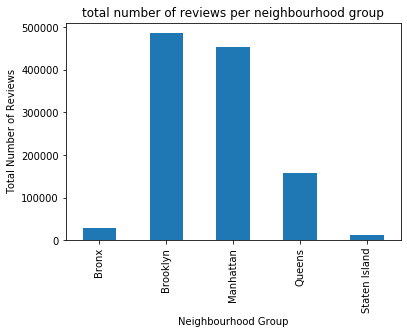

In [35]:
groups = airbnb.groupby("neighbourhood_group")["number_of_reviews"].sum().plot(kind="bar")
plt.ylabel("Total Number of Reviews")
plt.xlabel("Neighbourhood Group")
plt.title("total number of reviews per neighbourhood group")

### [5 pts] Plot map of airbnbs throughout New York (if it gets too crowded take a subset of the data, and try to make it look nice if you can :) ). 

Airbnb original set size: 586740
Airbnb_subset size: 213744
Saving figure better_NYC_airbnb_plot


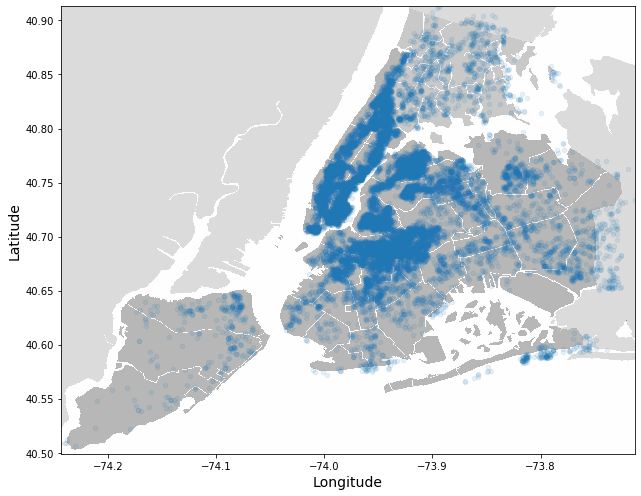

In [36]:
images_path = os.path.join('./', "images/")
os.makedirs(images_path, exist_ok=True)
filename = "NYC.png"

#take a subset of the dataset so that the plot looks pretty
sample = airbnb.dropna() #drop rows that contain null values
#to take a sample of the subset I drop values from Brooklyn and Manhattan since they are overcrowded and make the map look ugly
airbnb_subset = sample.drop(sample[((sample["neighbourhood_group"] == "Brooklyn") | 
                                    (sample["neighbourhood_group"] == "Manhattan")) & 
                                   ((sample["number_of_reviews"] < 60) & (sample["availability_365"] < 180))].index)
print("Airbnb original set size: " + str(airbnb.size))
print("Airbnb_subset size: " + str(airbnb_subset.size))

import matplotlib.image as mpimg
nyc_img = mpimg.imread(os.path.join(images_path, filename),0)
ax = airbnb_subset.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),alpha=0.1)

# overlay the NYC map on the plotted scatter plot
# note: plt.imshow still refers to the most recent figure
# that hasn't been plotted yet.
plt.imshow(nyc_img, extent=[-74.244, -73.713, 40.499, 40.913], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

save_fig("better_NYC_airbnb_plot")
plt.show()

### [5 pts] Plot average price of room types who have availability greater than 180 days. 

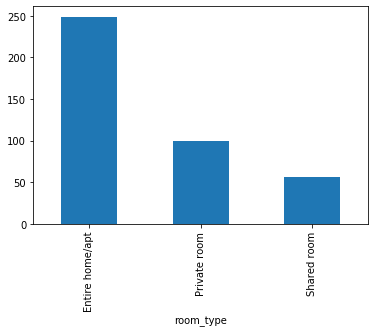

In [37]:
rooms_avail_180 = airbnb.drop(airbnb[(airbnb["availability_365"] <= 180)].index)

room_price = rooms_avail_180.groupby("room_type")["price"].sum()
room_count = rooms_avail_180.groupby("room_type")["price"].count()

av_room_price = (room_price/room_count).plot(kind="bar")

### [5 pts] Plot correlation matrix
- which features have positive correlation?
- which features have negative correlation?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000141737701C8>,
      dtype=object)

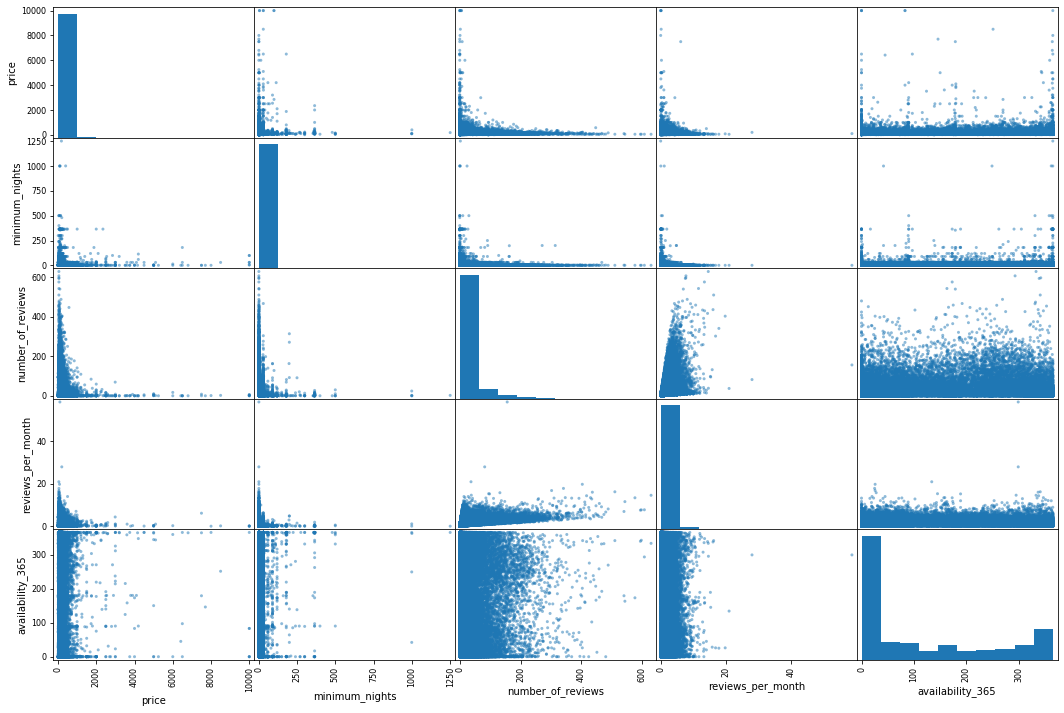

In [38]:
#airbnb_corr_matrix = airbnb.corr()
#print(airbnb_corr_matrix)
airbnb_attributes = ["price","minimum_nights","number_of_reviews","reviews_per_month","availability_365"]
scatter_matrix(airbnb[airbnb_attributes], figsize=(18,12))

# [25 pts] Prepare the Data

### [5 pts] Augment the dataframe with two other features which you think would be useful

In [39]:
airbnb["minimum_cost"] = airbnb["price"]*airbnb["minimum_nights"]
airbnb["minimum_earnings_per_year"] = airbnb["reviews_per_month"]*airbnb["minimum_cost"]*12

### [5 pts] Impute any missing feature with a method of your choice, and briefly discuss why you chose this imputation method

In [40]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

### [10 pts] Code complete data pipeline using sklearn mixins

In [41]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

airbnb_num = airbnb.drop(columns=["neighbourhood","neighbourhood_group","room_type","id"])

airbnb_num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

airbnb_num_tr = airbnb_num_pipeline.fit_transform(airbnb_num)
airbnb_num_features = list(airbnb_num)
airbnb_cat_features = ["neighbourhood","neighbourhood_group","room_type"]

airbnb_full_pipeline = ColumnTransformer([
    ("num", airbnb_num_pipeline, airbnb_num_features),
    ("cat", OneHotEncoder(sparse=False, handle_unknown='ignore'), airbnb_cat_features),
])

airbnb_prepared = airbnb_full_pipeline.fit_transform(airbnb)
airbnb_prepared = pd.DataFrame(airbnb_prepared)

### [5 pts] Set aside 20% of the data as test test (80% train, 20% test).

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(airbnb_prepared.drop(airbnb_prepared.columns[2], axis=1), airbnb_prepared[2], test_size=0.2, random_state=0)



# [15 pts] Fit a model of your choice

The task is to predict the price, you could refer to the housing example on how to train and evaluate your model using MSE.
Provide both test and train set MSE values.

In [43]:
from sklearn.linear_model import LinearRegression

airbnb_lin_reg = LinearRegression()
airbnb_lin_reg.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error

airbnb_preds = airbnb_lin_reg.predict(X_test)
mse = mean_squared_error(y_test, airbnb_preds)
print("Test mse value: ", mse)

airbnb_preds = airbnb_lin_reg.predict(X_train)
mse = mean_squared_error(y_train, airbnb_preds)
print("Train mse value: ", mse)


Test mse value:  0.6153495963161475
Train mse value:  0.6806895547681125
